In [290]:
# One for One multilabel classifier

In [291]:
import pandas as pd

In [292]:
import matplotlib.pyplot as plt

In [293]:
import seaborn

In [294]:
import numpy as np

In [295]:
import numpy

In [296]:
import nltk

In [297]:
import sklearn

In [298]:
from collections import Counter

In [299]:
%matplotlib inline 

In [374]:
data = pd.read_csv('full12.csv')
print("rows:", data.shape[0] - 1)
split = False

rows: 1182


In [375]:
labels = set()

tmp = data['label'].apply(lambda x: x.split(', '))
for label in tmp:
    labels = labels.union(label)
    
labels

{'achievement',
 'benevolence',
 'conformity',
 'hedonism',
 'none',
 'power',
 'security',
 'self-direction',
 'stimulation',
 'universalism'}

LABELS:
-----------------
[73, 46, 2, 80, 113, 146, 116, 13, 606, 33]
{'benevolence', 'hedonism', 'stimulation', 'self-direction', 'conformity', 'universalism', 'security', 'achievement', 'none', 'power'}


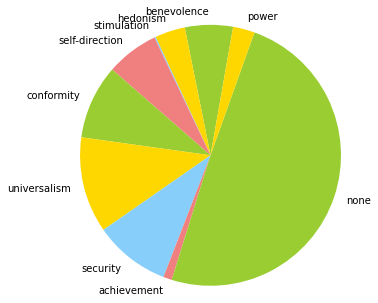

In [376]:
arr = []
print("LABELS:", end="\n-----------------\n")

labels_counter = {}

for label in labels:
    labels_counter[label] = 0

for data_labels in tmp:
    for label in labels:
        for data_label in data_labels:
            if data_label == label:
                labels_counter[label] += 1
            
labels_arr = []

for label_name, frequency in labels_counter.items():
    labels_arr.append(frequency)

print(labels_arr)
print(labels)
    
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0,0,0,0,0,0,0,0,0,0)
plt.pie(labels_arr, labels=labels, radius=1.5, colors=colors, explode=explode, shadow=False, startangle=80)
plt.savefig('label_distribution.jpg', dpi=1000)

In [377]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
models = {}
labels_to_ignore = []
for label in labels:
    if label not in labels_to_ignore:
        #models[label] = GradientBoostingClassifier(learning_rate=0.5, max_depth=6, min_samples_split= 3, n_estimators=120)
        models[label] = GradientBoostingClassifier(learning_rate=0.775, max_depth=8, min_samples_split= 3, n_estimators=120)

In [378]:
# Missing Data

In [379]:
# Turning label into arrays

In [380]:
split = False or split

if not split:
    data['label'] = data['label'].apply(lambda x: x.split(', '))
    #data['label'] = data['label'].apply(lambda x: [] if ['none'] == x else x)
    data['label'] = data['label'].apply(lambda x: np.array(x))
    split = True

In [381]:
# Splitting the dataset

In [382]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import math
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTEN, RandomOverSampler, SMOTE

number_of_samples = min(data.shape[0], 1000000)

data.drop(columns="location")
data.drop(columns="commentid")

X_train, X_test, y_train, y_test = train_test_split(data[0:number_of_samples],
                                                    data['label'][0:number_of_samples],
                                                    random_state=1, shuffle=False)
print("length of training set", end=": ")                                                   
print(round(100*len(X_train)/len(data))/100)
print("length of testing set", end=": ")                                                   
print(round(100*len(X_test)/len(data))/100)
col_to_incl = ['new_line', 'language']
X_train = X_train[col_to_incl]
X_test = X_test[col_to_incl]

length of training set: 0.75
length of testing set: 0.25


In [383]:
# Oversampling the dataset

In [384]:
from itertools import chain
from math import nan

def find_denom(li, v_count):
    try:
        res = sum(map(v_count.get, li)) / (len(li))
        #print(res)
        return res
    except:
        return nan


def oversample(x, y, len_mult=2, random_state=0) -> pd.DataFrame:
    df = pd.DataFrame()
    #print(x)
    df['y'] = y
    df['language'] = x['language']
    df['new_line'] = x['new_line']
    value_counts = Counter(chain(*df['y'].dropna()))
    #print(value_counts)
    denom = df['y'].map(lambda li: find_denom(li, value_counts), na_action='ignore')
    weights = 1 / (denom)
    weights.fillna(weights.sum() / weights.count(), inplace=True)
    #print(weights)
    extra_df = df.sample(
        len(df) * (len_mult-1), replace=True, weights=weights, random_state=random_state
    )
    df = pd.concat([df, extra_df])
    
    res_y = df['y']
    res_x = df[['new_line', 'language']]
    return res_x, res_y




In [385]:
oversampled_x_train, oversampled_y_train = oversample(X_train, y_train)

In [386]:
# Count Vectoriser

In [387]:
http_response_status_codes = np.linspace(100, 599, 500)
def process_out_noise(input):
    max_word_length = 18
    output = re.sub(r'\d+', '', input)
    w = re.findall(r'\w+', output)
    res = ""
    
    for word in w:
        if len(word) <= max_word_length:
            res += " " + word
    
    if output != '' and len(output) <= max_word_length:
        return output
    return res
    

In [388]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import scipy.sparse as sp
import re
from sklearn.feature_extraction.text import TfidfVectorizer

count_vector = CountVectorizer(min_df = 1, ngram_range=(1,3), max_df=1000, encoding='utf-8', analyzer='word')


res = []
length = X_train.shape[0]

def fit_training_data(training_data, testing_data, count_vector):

    training_data = training_data.apply(lambda col: col.str.strip())
    count_vector.fit(training_data.stack())
    training_data = training_data.apply(lambda x: count_vector.transform(x))
    training_data = sp.hstack(training_data )
    testing_data = sp.hstack(testing_data.apply(lambda x: count_vector.transform(x))) # print(type(x)))) #
    #joblib.dump(count_vector, 'vectorizer.pkl')
    return training_data, testing_data, count_vector

training_data, testing_data, count_vector = fit_training_data(oversampled_x_train, X_test, count_vector)


In [389]:
from imblearn.over_sampling import RandomOverSampler

In [390]:
models.keys()

dict_keys(['benevolence', 'hedonism', 'stimulation', 'self-direction', 'conformity', 'universalism', 'security', 'achievement', 'none', 'power'])

In [391]:
Counter(chain(*y_train.dropna()))

Counter({'self-direction': 69,
         'universalism': 115,
         'security': 92,
         'hedonism': 35,
         'none': 433,
         'benevolence': 57,
         'power': 25,
         'conformity': 88,
         'achievement': 10,
         'stimulation': 2})

In [392]:
Counter(chain(*oversampled_y_train.dropna()))

Counter({'self-direction': 166,
         'universalism': 208,
         'security': 187,
         'hedonism': 116,
         'none': 526,
         'benevolence': 158,
         'power': 107,
         'conformity': 182,
         'achievement': 85,
         'stimulation': 114})

In [393]:
def check_is_inside(item, arr):
        if item in arr:
            return 1
        else:
            return 0

In [394]:
for name, classifier in models.items():
    y_tmp = oversampled_y_train.apply(lambda x: check_is_inside(name, x))
    
    #tmp_X, tmp_Y = ROC.fit(training_data, y_train)
    print("fitting data for classifer:", classifier, "for", name)
    classifier.fit(training_data, y_tmp)

fitting data for classifer: GradientBoostingClassifier(learning_rate=0.775, max_depth=8,
                           min_samples_split=3, n_estimators=120) for benevolence
fitting data for classifer: GradientBoostingClassifier(learning_rate=0.775, max_depth=8,
                           min_samples_split=3, n_estimators=120) for hedonism
fitting data for classifer: GradientBoostingClassifier(learning_rate=0.775, max_depth=8,
                           min_samples_split=3, n_estimators=120) for stimulation
fitting data for classifer: GradientBoostingClassifier(learning_rate=0.775, max_depth=8,
                           min_samples_split=3, n_estimators=120) for self-direction
fitting data for classifer: GradientBoostingClassifier(learning_rate=0.775, max_depth=8,
                           min_samples_split=3, n_estimators=120) for conformity
fitting data for classifer: GradientBoostingClassifier(learning_rate=0.775, max_depth=8,
                           min_samples_split=3, n_estimat

In [395]:
# Prediction

In [396]:
len(y_test)

296

In [397]:
Counter(chain(*y_test))

Counter({'none': 173,
         'hedonism': 11,
         'conformity': 25,
         'universalism': 31,
         'self-direction': 11,
         'power': 8,
         'benevolence': 16,
         'security': 24,
         'achievement': 3})

In [398]:
for i in y_test:
    print(i)

['none']
['hedonism']
['conformity']
['none']
['none']
['none']
['universalism']
['none']
['none']
['self-direction']
['none']
['hedonism']
['power']
['conformity']
['conformity']
['none']
['none']
['none']
['self-direction']
['conformity']
['none']
['none']
['none']
['none']
['none']
['benevolence']
['none']
['none']
['none']
['self-direction']
['none']
['none']
['none']
['hedonism']
['none']
['none']
['none']
['none']
['none']
['none']
['none']
['universalism']
['none']
['none']
['self-direction']
['none']
['none']
['none']
['none']
['none']
['none']
['none']
['security' 'benevolence']
['none']
['self-direction']
['none']
['universalism']
['universalism']
['none']
['none']
['none']
['hedonism']
['none']
['none']
['none']
['none']
['none']
['self-direction']
['benevolence']
['none']
['conformity']
['none']
['none']
['universalism']
['security']
['benevolence']
['none']
['conformity']
['self-direction']
['self-direction']
['security']
['none']
['none']
['security']
['none']
['power']
[

In [399]:
n_y_test = y_test.values.tolist()

n_y_test = [['none'] if len(val) == 0 else val for val in n_y_test]

In [400]:
n_y_test

[array(['none'], dtype='<U4'),
 array(['hedonism'], dtype='<U8'),
 array(['conformity'], dtype='<U10'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['universalism'], dtype='<U12'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['self-direction'], dtype='<U14'),
 array(['none'], dtype='<U4'),
 array(['hedonism'], dtype='<U8'),
 array(['power'], dtype='<U5'),
 array(['conformity'], dtype='<U10'),
 array(['conformity'], dtype='<U10'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['self-direction'], dtype='<U14'),
 array(['conformity'], dtype='<U10'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['benevolence'], dtype='<U11'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['none'], dtype='<U4'),
 array(['self-direction']

In [401]:
def check_none_inside(arr):
    for item in arr:
        if item == 'none':
            return True
    
    return False

In [402]:
check_none_inside(['none', 'universalism'])

True

In [403]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

MLB = MultiLabelBinarizer()
MLB.fit(y_train)
tmp_y_test = MLB.transform((n_y_test))

predictions = []
f1 = []
accuracy = []
recall = []
precision = []

for i in range(len(y_test)):
    predictions.append([])

for name, classifier in models.items():
    tmp = classifier.predict(testing_data)
    res = []
    for i, item in enumerate(tmp):
        if item == 1:
            predictions[i].append(name)    

    n_predictions = [['none'] if check_none_inside(prediction) else prediction for prediction in predictions]
    n_predictions = [['none'] if len(prediction) == 0 else prediction for prediction in n_predictions]
    tmp_predictions = MLB.transform((n_predictions))

    print("For", name, "-----------------")
    print('Accuracy score: ', str(accuracy_score(tmp_y_test, tmp_predictions)))
    accuracy.append(accuracy_score(tmp_y_test, tmp_predictions))
    print('Precision score: ', str(precision_score(tmp_y_test, tmp_predictions, average='weighted', zero_division=0)))
    precision.append(precision_score(tmp_y_test, tmp_predictions, average='weighted', zero_division=0))
    print('Recall score: ', str(recall_score(tmp_y_test, tmp_predictions, average='weighted', zero_division=0)))
    recall.append(recall_score(tmp_y_test, tmp_predictions, average='weighted', zero_division=0))
    print('F1 score: ', str(f1_score(tmp_y_test, tmp_predictions, average='weighted',  zero_division=0)))
    f1.append(f1_score(tmp_y_test, tmp_predictions, average='weighted', zero_division=0))
    
    
print("AVEVERAGE", "-----------------")
print('Accuracy score: ', sum(accuracy)/len(accuracy))
print('Precision score: ', sum(precision)/len(precision))
print('Recall score: ', sum(recall)/len(recall))
print('F1 score: ', sum(f1)/len(f1))


For benevolence -----------------
Accuracy score:  0.6148648648648649
Precision score:  0.3909399869313753
Recall score:  0.6059602649006622
F1 score:  0.471198763636655
For hedonism -----------------
Accuracy score:  0.625
Precision score:  0.4255308946933131
Recall score:  0.6192052980132451
F1 score:  0.49490306323149136
For stimulation -----------------
Accuracy score:  0.625
Precision score:  0.4255308946933131
Recall score:  0.6192052980132451
F1 score:  0.49490306323149136
For self-direction -----------------
Accuracy score:  0.6351351351351351
Precision score:  0.45802284476935234
Recall score:  0.6291390728476821
F1 score:  0.513382570590396
For conformity -----------------
Accuracy score:  0.6621621621621622
Precision score:  0.5296345374964873
Recall score:  0.6622516556291391
F1 score:  0.5706361996844272
For universalism -----------------
Accuracy score:  0.7195945945945946
Precision score:  0.6457604126635147
Recall score:  0.7218543046357616
F1 score:  0.6647746708635578

In [404]:
tmp = []

#print(n_y_test[13])
def check_same(arr1, arr2):
    same = True
    for item in arr1:
        if item not in arr2:
            return False
        
    for item in arr2:
        if item not in arr1:
            return False
    
    return True
    
print("predicted", "actual")
for i, item in enumerate(n_predictions):
    if not check_same(n_y_test[i], item):
        print(item, "||", n_y_test[i])
    


predicted actual
['none'] || ['hedonism']
['none'] || ['conformity']
['self-direction', 'security'] || ['self-direction']
['none'] || ['conformity']
['conformity'] || ['none']
['none'] || ['benevolence']
['none'] || ['self-direction']
['none'] || ['hedonism']
['conformity'] || ['none']
['self-direction', 'security'] || ['universalism']
['none'] || ['self-direction']
['none'] || ['self-direction']
['none'] || ['self-direction']
['none'] || ['universalism']
['benevolence', 'conformity'] || ['benevolence']
['none'] || ['self-direction']
['universalism'] || ['none']
['none'] || ['universalism']
['none'] || ['hedonism' 'benevolence']
['none'] || ['security']
['power'] || ['none']
['none'] || ['security']
['conformity', 'security'] || ['security']
['none'] || ['benevolence']
['none'] || ['benevolence']
['none'] || ['conformity']
['none'] || ['security']
['universalism'] || ['none']
['conformity', 'universalism'] || ['benevolence']
['none'] || ['hedonism']
['conformity', 'universalism'] || ['

In [405]:
import joblib

In [409]:
joblib.dump(count_vector, 'c.pkl')
joblib.dump(MLB, 'b.pkl')

for name, model in models.items():
    joblib.dump(model, name + '.pkl')